In [1]:
import json
from pathlib import Path
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
raw_data = Path("data/GVFC_extension_multimodal.csv")

In [3]:
df = pd.read_csv(raw_data)

In [4]:
len(df)

1300

In [41]:
df.head()

,id,article_url,headline,google_visual_api_web_entities_detection_on_lead_image,automatically_generated_caption_of_lead_image,lead_3_sentences_summary_of_full_article_text,presum_summary_of_full_article_text,Q1 Relevant,Q2 Focus,Q3 Theme1,Q3 Theme2,V1image,V2ethnicity,V3relevance,V4relevance,Q4 Image1,Q4 Image2
0,0,http://beta.latimes.com/nation/la-na-paddock-c...,Cremated remains of Las Vegas mass shooter to ...,Stephen Paddock 2017 Las Vegas Strip shooting ...,"Eric Paddock, center, with his brother Eric Pa...","""Cremated remains of Las Vegas mass shooter to...","""cremated remains of las vegas mass shooter to...",1,2,7,99,1,0,0,99.0,6,99
1,1,https://www.yahoo.com/news/florida-shooter-tro...,Florida shooter a troubled loner with white su...,Nikolas Cruz Stoneman Douglas High School shoo...,"A photograph of the suspect, Nikolas Cruz.",Parkland (Etats-Unis) (AFP) - Nikolas Cruz was...,nikolas cruz was expelled from school after be...,1,1,4,6,1,0,1,0.0,7,0
2,2,http://www.chicagotribune.com/suburbs/lake-cou...,Vernon Hills teen accused of wearing white sup...,Vernon Hills FOID Firearm Ammunition White su...,"Zak, who is charged with carrying a gun, is ch...",Zak had been the subject of a CLC campus threa...,zak had been the subject of a clc campus threa...,1,1,6,99,1,0,0,99.0,0,99
3,3,http://www.chicagotribune.com/suburbs/post-tri...,Griffith student charged with accidentally bri...,Arrest Student Expulsion School Felony Ada Cou...,A student was charged with carrying a gun in a...,"""The members of our staff have been trained on...","""the members of our staff have been trained on...",1,1,5,99,1,0,0,99.0,0,99
4,4,http://www.cnn.com/2018/02/16/us/exclusive-sch...,Exclusive: Group chat messages show school sho...,Nikolas Cruz Stoneman Douglas High School shoo...,A photo from a Facebook page of the school sho...,"(CNN) In a private Instagram group chat, confe...",the fbi is investigating a private chat group ...,1,1,4,6,1,0,1,0.0,8,0


In [42]:
df["text"] = df["headline"] + " " + df["presum_summary_of_full_article_text"]

In [43]:
# remove columns ["article_url", "headline", "presum_summary_of_full_article_text", "id", "google_visual_api_web_entities_detection_on_lead_image", "automatically_generated_caption_of_lead_image", "V1image", "V2ethnicity", "V3relevance", "V4relevance", "Q4 Image1", "Q4 Image2"]
df = df.drop(columns=["lead_3_sentences_summary_of_full_article_text", "article_url", "headline", "presum_summary_of_full_article_text", "id", "google_visual_api_web_entities_detection_on_lead_image", "automatically_generated_caption_of_lead_image", "V1image", "V2ethnicity", "V3relevance", "Q4 Image1", "Q4 Image2", "V4relevance", "Q3 Theme2", "Q1 Relevant"])

In [44]:
theme_mapping = {
    1: "Gun/2nd Amendment rights",
    2: "Gun control/regulation",
    3: "Politics",
    4: "Mental health",
    5: "School or public space safety",
    6: "Race/ethnicity",
    7: "Public opinion",
    8: "Society/culture",
    9: "Economic consequences",
    99: "None of the above",
}

In [45]:
# drop all rows where Q3 Theme1 is 99
df = df[df["Q3 Theme1"] != 99]

In [46]:
df.head()

,Q2 Focus,Q3 Theme1,text
0,2,7,Cremated remains of Las Vegas mass shooter to ...
1,1,4,Florida shooter a troubled loner with white su...
2,1,6,Vernon Hills teen accused of wearing white sup...
3,1,5,Griffith student charged with accidentally bri...
4,1,4,Exclusive: Group chat messages show school sho...


<Axes: xlabel='Q3 Theme1', ylabel='count'>

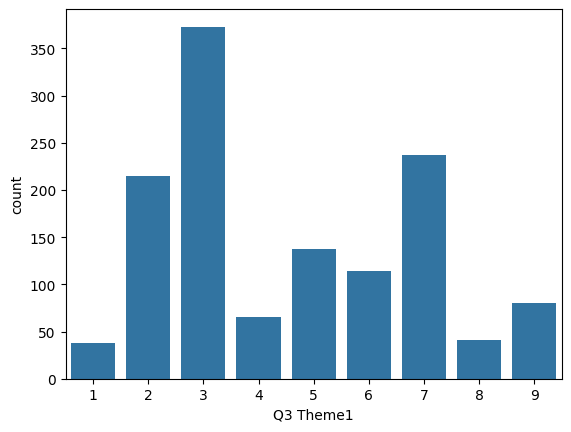

In [48]:
sns.countplot(data=df, x="Q3 Theme1")

In [49]:
# Map Q3 Theme1 to frame
df["frame"] = df["Q3 Theme1"].map(theme_mapping)
df = df.drop(columns=["Q3 Theme1"])

In [50]:
df.head()

,Q2 Focus,text,frame
0,2,Cremated remains of Las Vegas mass shooter to ...,Public opinion
1,1,Florida shooter a troubled loner with white su...,Mental health
2,1,Vernon Hills teen accused of wearing white sup...,Race/ethnicity
3,1,Griffith student charged with accidentally bri...,School or public space safety
4,1,Exclusive: Group chat messages show school sho...,Mental health


In [52]:
# construct two dataframes:
# the first one should include 16 samples per column frame for training
# the second one should include the rest of the samples for testing
train_df = pd.DataFrame(columns=df.columns)
test_df = pd.DataFrame(columns=df.columns)
for frame in df["frame"].unique():
    frame_df = df[df["frame"] == frame]
    train_frame_df, test_frame_df = train_test_split(frame_df, train_size=16, random_state=42)
    train_df = pd.concat([train_df, train_frame_df])
    test_df = pd.concat([test_df, test_frame_df])

In [56]:
# Print some statistics about the DataFrame

for df in [train_df, test_df]:
    # length of the dataframe
    print(f"Number of rows in the DataFrame: {len(df)}")

    # number of unique frames
    print(f"Number of unique frames: {df['frame'].nunique()}")  

Number of rows in the DataFrame: 144
Number of unique frames: 9
Number of rows in the DataFrame: 1156
Number of unique frames: 9


In [57]:
def plot_column_distribution(dataframe, column_name):
    """
    Plots the distribution of a specified column in the DataFrame.
    Args:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to plot.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.countplot(data=dataframe, x=column_name, order=dataframe[column_name].value_counts().index)
    plt.title(f"Distribution of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

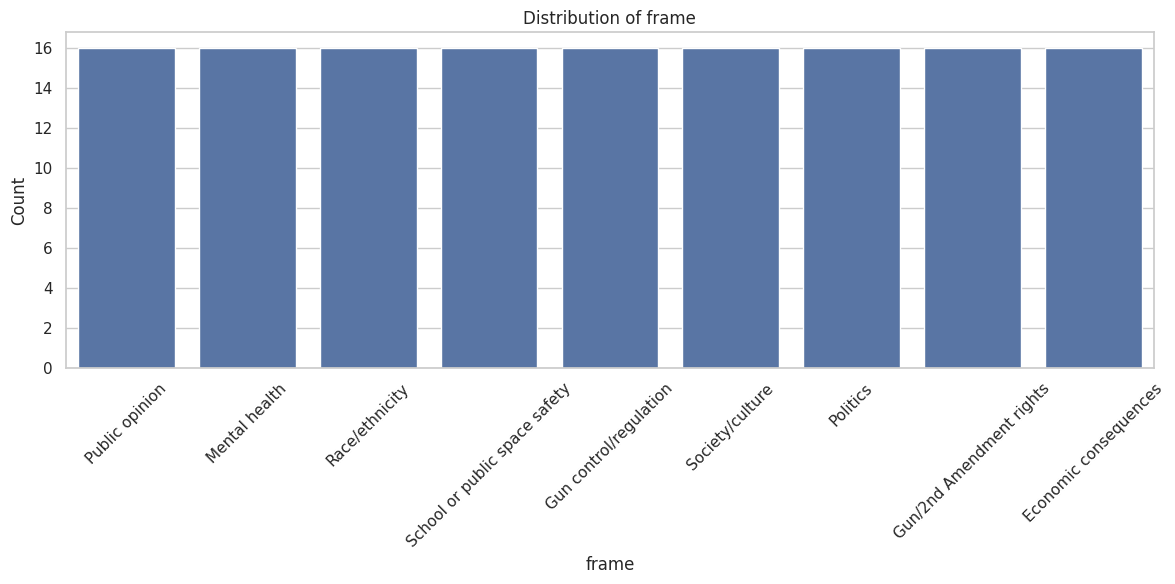

In [58]:
plot_column_distribution(train_df, "frame")

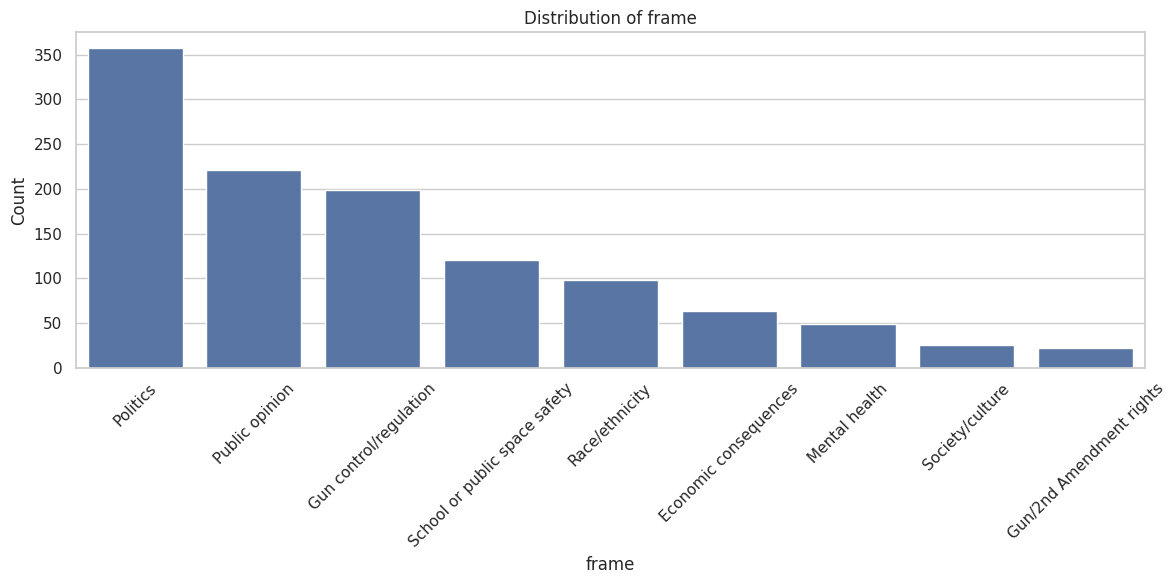

In [59]:
plot_column_distribution(test_df, "frame")

In [60]:
# save the dataframes to parquet
parquet_output_path = Path("data/gvfc_train.parquet")
train_df.to_parquet(parquet_output_path, index=False)
parquet_output_path = Path("data/gvfc_test.parquet")
test_df.to_parquet(parquet_output_path, index=False)